In [1]:
import psycopg2 as pg2
import pandas as pd
from datetime import datetime
import BuildModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
import BuildModel
import importlib
from matplotlib import pyplot as plt
from PrevInfo import PrevInfo
from datetime import date, timedelta
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
def get_list_of_dates():

    sdate = datetime(2020, 2, 13)   # start date
    edate = datetime(2020, 2, 16)   # end date

    delta = edate - sdate       # as timedelta

    return [sdate + timedelta(days=i) for i in range(delta.days + 1)]
        

In [3]:
def get_actual_and_potential_profits(Xin, yin):
    potential_profits =  (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    actual_profits = yin * (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    return potential_profits, actual_profits

In [4]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full where auctiontime >= '2020-01-01'""", conn)

print ("Splitting into Train/Test Sets")
df = df.sort_values("auctiontime")

Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [5]:
X = df
y = df['is_winner']

In [8]:
df

,auctionid,is_winner,cardtype,cashvalue,cardvalue,fee,bidvalue,limited_allowed,is_locked,auctiontime,...,bom_streak3,perc_to_bin3,prev_is_new_user3,prev_auction_count3,prev_overbid3,prev_giveup_one3,prev_give_before_six3,prev_wins3,prev_bids3,prev_bom_bids3
30824,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.013793,0.0,78.0,0.000000,0.346154,0.756410,0.000000,4.179487,0.333333
30747,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30746,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30745,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30744,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397251,470101697,False,None,10,0,0.00,25,True,False,2020-03-02 23:59:02,...,0.0,0.040000,0.0,1679.0,0.130435,0.150685,0.266230,0.141155,51.960691,44.724241
4397252,470101697,False,None,10,0,0.00,25,True,False,2020-03-02 23:59:02,...,0.0,0.040000,0.0,1679.0,0.130435,0.150685,0.266230,0.141155,51.960691,44.724241
4397253,470101697,False,None,10,0,0.00,25,True,False,2020-03-02 23:59:02,...,0.0,0.040000,0.0,1679.0,0.130435,0.150685,0.266230,0.141155,51.960691,44.724241
4397245,470101697,False,None,10,0,0.00,25,True,False,2020-03-02 23:59:02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
importlib.reload(BuildModel)
print ("Fitting Model")
#def create_model():
    # Define a Keras model
#    model = Sequential()

#    # Add a Dense layer that uses the sigmoid function
#    model.add(Dense(units=30, kernel_initializer='random_uniform',
#                bias_initializer='zeros', activation='relu', input_dim=74))
#    model.add(Dense(units=30, kernel_initializer='random_uniform',
#                bias_initializer='zeros',  activation='relu'))
#    model.add(Dense(units=1, activation='sigmoid'))
#    
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

#clf = KerasClassifier(build_fn=create_model,epochs=5,batch_size=10)

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
#model = clf

pm = BuildModel.PennyModel(model, sampling_ratio=.5 )

Fitting Model


In [14]:
train_cut_off  = datetime(2020, 2, 15) 
test_cut_off = datetime(2020, 3, 2)
profits = []
dates = get_list_of_dates()
for i in range(1, len(dates)):
    train_cut_off = dates[i-1]
    test_cut_off = dates[i]
    print(train_cut_off, test_cut_off)
    X_train = X[X.auctiontime <= train_cut_off]
    y_train = y[X.auctiontime <= train_cut_off]

    X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

    X_holdout = X[X.auctiontime > test_cut_off]
    y_holdout = y[X.auctiontime > test_cut_off]

    pm.fit_transform(X_train, y_train)
    print(pm.get_score(X_test, y_test))
    #   cprobs = pm.predict_proba_calibrated(X_test)[:,1]
 #   pp, ap = get_actual_and_potential_profits(X_test,y_test)
 #   expected_value = np.multiply(cprobs, pp) -  (1-cprobs)*.4
 #   profits.append(
#    (sum(ap[expected_value>0]), X_test.shape[0], sum(expected_value>0), sum((ap > 0) & (expected_value >0)), 
#    sum((ap > 0) & (expected_value < 0)), sum((ap < 0)&(expected_value > 0)), sum((ap < 0)&(expected_value < 0))))

    
    # (3450.019999999662, 66260, 6801, 136, 248, 6665, 59211),

2020-02-13 00:00:00 2020-02-14 00:00:00


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ubuntu/PennyAuction/src/BuildModel.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fee"]=[0 if x == 0 else (1 if x < 50 else 1.99) for x in X["cardvalue"]]
/home/ubuntu/PennyAuction/src/BuildModel.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

4. Fitting model


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-96cb5dc6035c>", line 19, in <module>
    print(pm.get_score(X_test, y_test))
  File "/home/ubuntu/PennyAuction/src/BuildModel.py", line 246, in get_score
    cprobs = self.predict_proba_calibrated(X)[:,1]
  File "/home/ubuntu/PennyAuction/src/BuildModel.py", line 189, in predict_proba_calibrated
    return self.calibrate_probabilties(self.predict_proba(X))
  File "/home/ubuntu/PennyAuction/src/BuildModel.py", line 180, in predict_proba
    return self.pipeline.predict_proba(self.transform(X))
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py", line 116, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py", line 471, 

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [19]:
cprobs = pm.predict_proba(X_test)[:,1]
 #   pp, ap = get_actual_and_potential_profits(X_test,y_test)
 #   expected_value = np.multiply(cprobs, pp) -  (1-cprobs)*.4
 #   profits.append(
#    (sum(ap[expected_value>0]), X_test.shape[0], sum(expected_value>0), sum((ap > 0) & (expected_value >0)), 
#    sum((ap > 0) & (expected_value < 0)), sum((ap < 0)&(expected_value > 0)), sum((ap < 0)&(expected_value < 0))))

    
    # (3450.019999999662, 66260, 6801, 136, 248, 6665, 59211),

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-144d0c5c64d6>", line 1, in <module>
    cprobs = pm.predict_proba(X_test)[:,1]
  File "/home/ubuntu/PennyAuction/src/BuildModel.py", line 180, in predict_proba
    return self.pipeline.predict_proba(self.transform(X))
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py", line 116, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py", line 471, in predict_proba
    Xt = transform.transform(Xt)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py", line 560, in transform
    X = _check_X(X)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/compose/_column_tran

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
sum(ap[expected_value> 0])

In [ ]:
X_test[expected_value>0].shape

In [286]:
cprobs = pm.predict_proba_calibrated(X_test)[:,1]

In [287]:
pp, ap = get_actual_and_potential_profits(X_test,y_test)

In [288]:
cprobs

array([0.0144757 , 0.00162359, 0.01477301, ..., 0.01707009, 0.00915571,
       0.03665048])

In [289]:
expected_value = np.multiply(cprobs, pp) -  (1-cprobs)*.4

In [290]:
sum(ap[expected_value>0])

29507.109999939235

1619
97421
931018


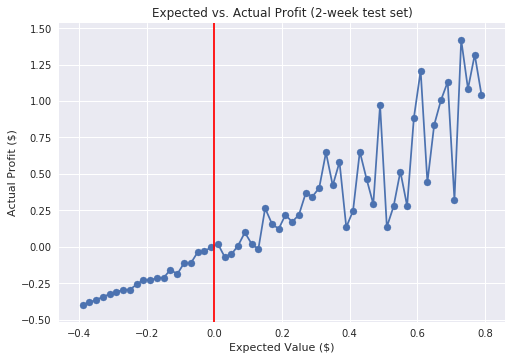

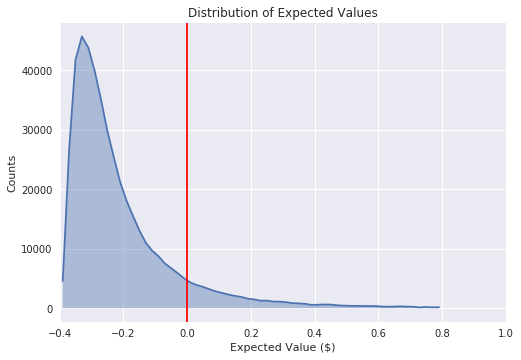

In [557]:
exs = []
acs = []
counts = []
bin_size=.02
for i in np.arange (-1, .8, bin_size):
    my_profit = ap[(expected_value > i)&(expected_value < i + bin_size/2)]
    num_bids = my_profit.shape[0]
    if (num_bids > 0):
        exs.append (i + bin_size/2)
        acs.append (sum(my_profit)/num_bids)
        counts.append(num_bids)
fig, ax = plt.subplots()
ax.plot(exs, acs)
ax.scatter(exs, acs)
ax.set_xlabel("Expected Value ($)")
ax.set_ylabel("Actual Profit ($)")
ax.set_title("Expected vs. Actual Profit (2-week test set)")
ax.axvline(x=0, color="red")

fig, ax = plt.subplots()
ax.plot(exs, counts)
ax.set_xlim(left=-.4, right=1)
ax.axvline(x=0, color="red")
ax.fill_between(exs, 0, counts, alpha=.4)
ax.set_xlabel("Expected Value ($)")
ax.set_ylabel("Counts")
ax.set_title("Distribution of Expected Values")
print(sum((ap > 0) & (expected_value >0)))
print(sum(expected_value > 0))
print(len(expected_value))

In [23]:
profit_sum = 0
bets_sum = 0
for b in buckets:
    bets_sum += b[2]
    profit_sum += b[1]
print(bets_sum, profit_sum, profit_sum/bets_sum)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-3af89442dda1>", line 3, in <module>
    for b in buckets:
NameError: name 'buckets' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda3/lib/pyth

NameError: name 'buckets' is not defined

In [345]:
pm.pickle(filename="rf.pkl")

5. Pickling model as penny_auction.pickle


2. Transforming data


31476.382150766545

2. Transforming data


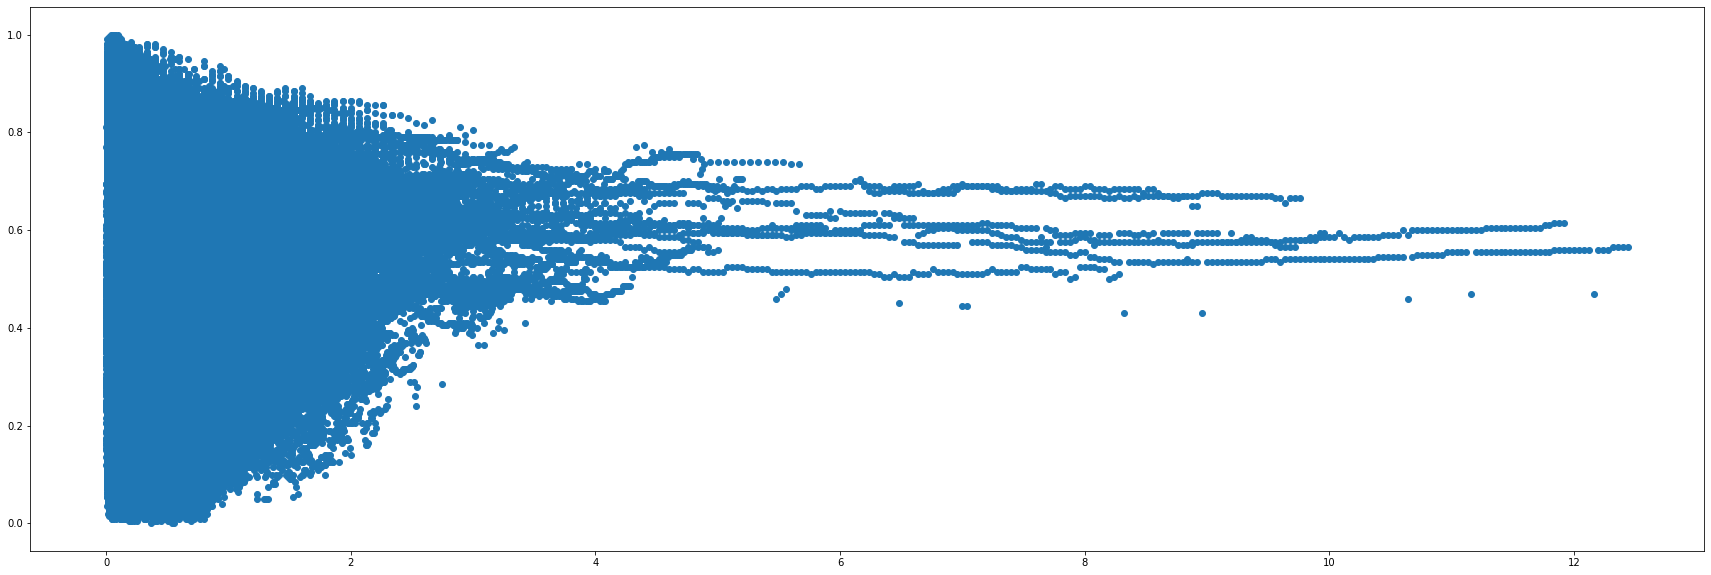

In [89]:
f = "perc_to_bin0"
amazon_50_30 = X_test  #[(X_test.cardtype=="Amazon")&(X_test.bidvalue==100)&(X_test.cardvalue==0)]
test_df = amazon_50_30.sort_values(f)
preds = pm.predict_proba(test_df)[:,1]
preds
fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(test_df[f], preds)

# Random Forest:   26,480/25,802

2. Transforming data
-12.889999999999981
12677 167
****************
116.55000000000005
31997 1063
****************
796.9400000000511
64775 2711
****************
10233.650000004822
241665 25121
****************
8841.890000006097
277041 31694
****************
3729.1299999994367
87788 11464
****************
222.17000000000255
25397 360
****************
23927.44000001041


In [348]:
pi = PrevInfo()
pi.pickle ("pi.pkl")

Connecting to SQL


In [83]:
buckets

[((0, 5.7, 0.98),
  17.000000000000195,
  array([False, False, False, ..., False, False, False])),
 ((5.7, 9.7, 0.9),
  133.39999999999512,
  array([False, False, False, ..., False, False, False])),
 ((9.7, 19.7, 0.78),
  1085.3100000000218,
  array([False, False, False, ..., False, False, False])),
 ((19.7, 40, 0.66),
  16661.16000000705,
  array([ True, False,  True, ..., False,  True, False])),
 ((40, 62, 0.52),
  17653.790000007873,
  array([ True, False,  True, ...,  True,  True, False])),
 ((62, 100, 0.48),
  4531.390000000543,
  array([ True, False,  True, ...,  True,  True,  True])),
 ((100, 200, 0.5700000000000001),
  577.9500000000024,
  array([ True, False,  True, ..., False,  True, False]))]

In [472]:
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
def shuffle_column(X, feature_index):
    ''' 
    Parameters
    ----------
    X: numpy array
    feature_index: int
    
    Returns
    -------
    X_new: numpy array
    
    Returns a new array identical to X but
    with all the values in column feature_index
    shuffled
    '''   
    
    X_new = X.copy()
    X_new[feature_index] = np.random.permutation(X_new[feature_index])
    return X_new    

def permutation_importance(model, X_test, y_test, scorer=accuracy_score):
    ''' Calculates permutation feature importance for a fitted model
    
    Parameters
    ----------
    model: anything with a predict() method
    X_test, y_test: numpy arrays of data
        unseen by model
    scorer: function. Should be a "higher is better" scoring function,
        meaning that if you want to use an error metric, you should
        multiply it by -1 first.
        ex: >> neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)
            >> permutation_importance(mod, X, y, scorer=neg_mse)
    
    Returns
    -------
    feat_importances: numpy array of permutation importance
        for each feature
    
    '''
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, X_test.columns[i])
        test_score_permuted = scorer(y_test, model.predict(X_test_shuffled))
        print(test_score, test_score_permuted)
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

In [473]:
pis = permutation_importance(pm, X_test, y_test)

0.8815941259997121 0.8815941259997121
0.8815941259997121 0.8815941259997121
0.8815941259997121 0.8830581148807005


KeyboardInterrupt: 

In [ ]:
for c, pi in sorted(zip(X_test.columns, pis), key=lambda x: abs(x[1])):
    print(c, pi)
    
key=lambda x: x[1]

Plotting features


Text(0.5, 0, 'Average contribution to information gain')

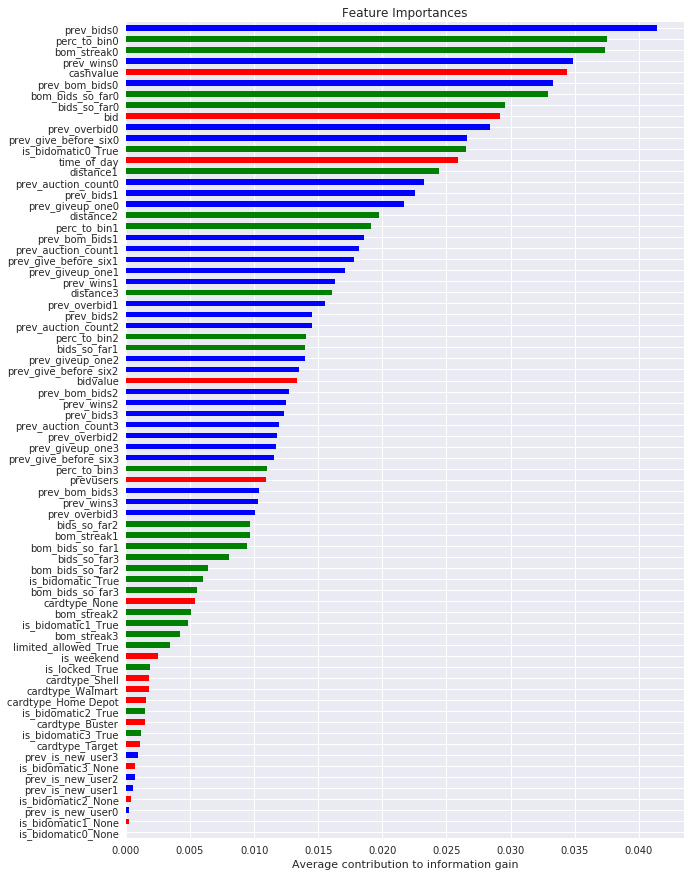

In [15]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
colors = []
for fs in feat_scores.iteritems():
    if (fs[0].startswith('prev') and not fs[0]=="prevusers"):
        colors.append("blue")
    elif (fs[0].endswith('0') or fs[0].endswith('1') or fs[0].endswith('2') or fs[0].endswith('3') or fs[0].endswith("_True")):
        colors.append("green")
    else:
        colors.append("red")
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,15),
                      color=colors)
ax.set_title('Feature Importances')
ax.set_xlabel('Average contribution to information gain')


In [442]:
feat_scores.iter_items()

AttributeError: 'Series' object has no attribute 'iter_items'

In [459]:
X_test.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue', 'fee',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'giveup',
       'eventual_bids', 'eventual_win_price', 'debut', 'bom_streak',
       'bom_bids_so_far', 'perc_to_bin', 'username0', 'distance0',
       'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0', 'bom_streak0',
       'perc_to_bin0', 'prev_is_new_user0', 'prev_auction_count0',
       'prev_overbid0', 'prev_giveup_one0', 'prev_give_before_six0',
       'prev_wins0', 'prev_bids0', 'prev_bom_bids0', 'username1', 'distance1',
       'is_bidomatic1', 'bids_so_far1', 'bom_bids_so_far1', 'bom_streak1',
       'perc_to_bin1', 'prev_is_new_user1', 'prev_auction_count1',
       'prev_overbid1', 'prev_giveup_one1', 'prev_give_before_six1',
       'prev_wins1', 'prev_bids1', 'prev_bom_bids1', 'username2', 'distance2',
       'is_bidomatic2', 'bids_so_far2', 'bom_bids_so_far2', 

In [499]:


# Use the roc_curve method to create false positive rates, true positive rates
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Use these rates to generate an 'area under the curve score', print it
r_auc = auc(fpr, tpr)

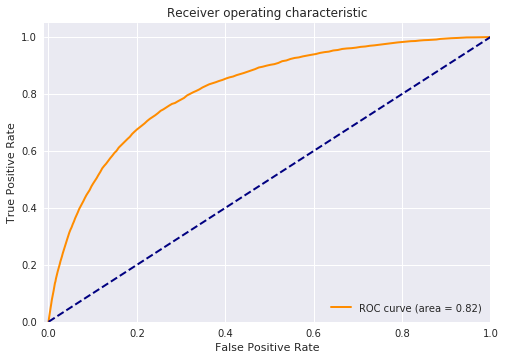

In [501]:
# Plot the ROC curve.
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % r_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [563]:
profits

[(2091.129999999336, 74023, 9059, 134),
 (1877.8399999996818, 56999, 7642, 120),
 (1463.7699999999295, 55473, 6655, 106),
 (3953.879999999448, 67957, 8254, 176),
 (3882.959999999555, 75405, 8066, 165),
 (2320.6899999998986, 55111, 5174, 97),
 (1555.349999999928, 74218, 6275, 95),
 (2249.049999999554, 66393, 8064, 127),
 (1577.5799999997694, 60036, 7196, 120),
 (402.0000000001004, 62701, 6878, 83),
 (2035.859999999706, 55667, 5624, 117),
 (1608.569999999938, 55649, 4622, 86),
 (1903.86999999968, 60730, 6619, 109)]

In [564]:
my_ps = [p[0] for p in profits]

In [565]:
my_ps


[2091.129999999336,
 1877.8399999996818,
 1463.7699999999295,
 3953.879999999448,
 3882.959999999555,
 2320.6899999998986,
 1555.349999999928,
 2249.049999999554,
 1577.5799999997694,
 402.0000000001004,
 2035.859999999706,
 1608.569999999938,
 1903.86999999968]

In [572]:
my_ds = [str(d).split()[0] for d in get_list_of_dates()]

In [573]:
my_ds

['2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28']

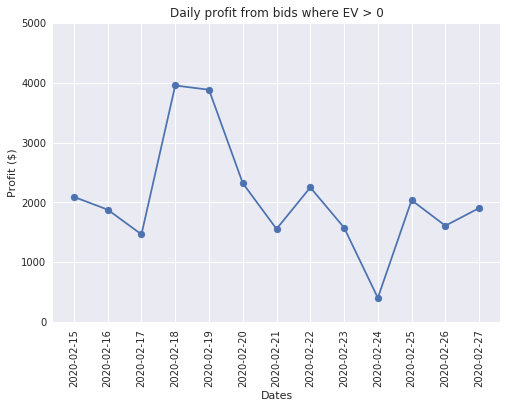

In [595]:
fig, ax =plt.subplots()
ax.scatter(my_ds[:-1], my_ps)
ax.plot(my_ds[:-1], my_ps)
ax.set_ylim(0, 5000)
ax.set_xlabel("Dates")
ax.set_ylabel("Profit ($)")
ax.set_title("Daily profit from bids where EV > 0")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [589]:
profits

[(2091.129999999336, 74023, 9059, 134),
 (1877.8399999996818, 56999, 7642, 120),
 (1463.7699999999295, 55473, 6655, 106),
 (3953.879999999448, 67957, 8254, 176),
 (3882.959999999555, 75405, 8066, 165),
 (2320.6899999998986, 55111, 5174, 97),
 (1555.349999999928, 74218, 6275, 95),
 (2249.049999999554, 66393, 8064, 127),
 (1577.5799999997694, 60036, 7196, 120),
 (402.0000000001004, 62701, 6878, 83),
 (2035.859999999706, 55667, 5624, 117),
 (1608.569999999938, 55649, 4622, 86),
 (1903.86999999968, 60730, 6619, 109)]

In [590]:
sum(ap>0)

316

In [593]:
sum(ap[expected_value > 0])

1903.86999999968

In [14]:
profits


[(2413.7599999996237, 74663, 6785, 118, 266, 6667, 67612),
 (3589.549999999681, 66260, 6553, 138, 246, 6415, 59461),
 (1904.1299999993225, 74023, 9260, 133, 253, 9127, 64510)]

In [17]:
ev

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2cf3baf58f53>", line 1, in <module>
    ev
NameError: name 'ev' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/

NameError: name 'ev' is not defined